### Large Data Problem

If the size of the data is very large (large number of time series; each time series consisting of large number of samples), we face two types of challenges: 

- Large execution time (Compute bound problem)
- Need for larger memory (Memory bound problem)

#### Large Execution Time
If the data fits into main memory(RAM), `tsfresh` solves the large execution time problem, by utlizing
- **multiple processors in a single machine** (using `multiprocessing` package). This is the default option. Whenever, `tsfresh` package is used, multiprocessing is switched on by default. Number of processors/cores to be used can be cotrolled using `n_jobs` flag.
- **multiple processors spread across multiple machines** (Cluster/Distributed Computing). `tsfresh.utilities.distribution` module consists of various distributors including Dask based `tsfresh.utilities.distribution.ClusterDaskDistributor`. `ClusterDaskDistributor` distributes the job across various workers in a Dask cluster.

#### Need for larger memory
For data that doesn't fit into main memory (RAM), `tsfresh` utilizes `Dask` for out of core computation and for distributing the data across multiple machines in a cluster. `tsfresh` provides convenience function for this: `tsfresh.convenience.bindings.dask_feature_extraction_on_chunk`.

It's worth mentioning, `tsfresh` provides convenience function which addresses large data issue using **Apache Spark** as well (`tsfresh.convenience.bindings.spark_feature_extraction_on_chunk()`). However, this notebook focuses only on Dask.

In [1]:
import glob
import os
import sys

import pandas as pd
import numpy as np

import dask
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd

In [2]:
def get_segment_id_from_path(df, path):
    """
    Returns the segment_id from the path of the file 
    """
    df.segment_id = df.segment_id.str.replace(path, "")
    df.segment_id = df.segment_id.str.replace(".csv", "")
    df.segment_id = df.segment_id.astype(np.int64)
    
    return df

def append_time_column(df):
    df["time"] = range(0, len(df))
    
    return df

In [3]:
DATA_DIR = "/datadrive/arnab/vssexclude/feature_engineering_with_tsfresh/data/raw/train"

# Define the datatypes for different sensor data
data_types = {"sensor_1" : np.float32, 
                 "sensor_2" : np.float32, 
                 "sensor_3" : np.float32,
                 "sensor_4" : np.float32,
                 "sensor_5" : np.float32,
                 "sensor_6" : np.float32,
                 "sensor_7" : np.float32,
                 "sensor_8" : np.float32,
                 "sensor_9" : np.float32,
                 "sensor_10" : np.float32}

### Start Dask Client

<img src="../images/dask_architechture_diagram.png" width="600" height="200" style="border-style: solid;">

Create a LocalCluster with client, scheduler and worker running on the same machine. The scheduler will run on port 8786.

By specifying `n_worker=8`, we have asked to dask to start `8` independent python processes. Based on the nature of the cluster, they may run in the same machine or different machines. In our case, the processes have been started in this machine.

In [17]:
cluster = LocalCluster(n_workers=8, 
                       threads_per_worker=1, 
                       scheduler_port=8786, 
                       memory_limit='2GB')

In [18]:
client = Client(cluster)

In [19]:
client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 16.00 GB


### Read Data

## ClusterDaskDistributor

When data fits into memory, but we need to distribute the feature engineering job across the cluster.

- Data is loaded using Pandas DataFrame, i.e. entire data is loaded into RAM
- Extracted features is also a Pandas DataFrame

In [20]:
df = pd.DataFrame()
for name in glob.glob(f"{DATA_DIR}/140*"):
    temp_df = pd.read_csv(name, dtype=data_types, nrows=1000)
    
    # Extract name of the segment from the file name
    segment_id = int(name.split(".")[0].split("/")[-1])
    temp_df["segment_id"] = segment_id
    print(f"Reading data for segment: {segment_id}")
    
    # Create a column named time
    temp_df["time"] = range(0, len(temp_df))
    
    df = df.append(temp_df)
    
print("\n")    
print(f"Shape of the dataframe consisting of all data from above files: {df.shape}")

Reading data for segment: 1400253000
Reading data for segment: 140031872
Reading data for segment: 1400727315
Reading data for segment: 1400929225
Reading data for segment: 1402556914
Reading data for segment: 1402674973
Reading data for segment: 1402914692
Reading data for segment: 1403005697
Reading data for segment: 1403222059
Reading data for segment: 1403244730
Reading data for segment: 1403440092
Reading data for segment: 140348256
Reading data for segment: 1403947680
Reading data for segment: 1404122310
Reading data for segment: 1404179874
Reading data for segment: 1404322654
Reading data for segment: 1404502479
Reading data for segment: 1405189645
Reading data for segment: 1405443107
Reading data for segment: 1406234149
Reading data for segment: 1406456924
Reading data for segment: 1406626451
Reading data for segment: 1406938061
Reading data for segment: 1407084157
Reading data for segment: 1407094442
Reading data for segment: 1407261706
Reading data for segment: 1408285202
Rea

In [21]:
df  = df.loc[:, ["segment_id", "time", "sensor_1", "sensor_4"]]
df.head()

,segment_id,time,sensor_1,sensor_4
0,1400253000,0,-486.0,-516.0
1,1400253000,1,-567.0,-591.0
2,1400253000,2,-631.0,-620.0
3,1400253000,3,-744.0,-550.0
4,1400253000,4,-725.0,-475.0


In [22]:
from tsfresh.utilities.distribution import ClusterDaskDistributor

dask_distributor = ClusterDaskDistributor(address="127.0.0.1:8786")

In [23]:
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction.settings import MinimalFCParameters
from tsfresh.feature_extraction.settings import EfficientFCParameters
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters

extracted_features = extract_features(timeseries_container=df,
                     column_id='segment_id', column_sort='time',
                     default_fc_parameters=ComprehensiveFCParameters(),
                     distributor=dask_distributor)

In [16]:
dask_distributor.close()

In [17]:
extracted_features.head()

,sensor_1__variance_larger_than_standard_deviation,sensor_1__has_duplicate_max,sensor_1__has_duplicate_min,sensor_1__has_duplicate,sensor_1__sum_values,sensor_1__abs_energy,sensor_1__mean_abs_change,sensor_1__mean_change,sensor_1__mean_second_derivative_central,sensor_1__median,...,sensor_4__fourier_entropy__bins_2,sensor_4__fourier_entropy__bins_3,sensor_4__fourier_entropy__bins_5,sensor_4__fourier_entropy__bins_10,sensor_4__fourier_entropy__bins_100,sensor_4__permutation_entropy__dimension_3__tau_1,sensor_4__permutation_entropy__dimension_4__tau_1,sensor_4__permutation_entropy__dimension_5__tau_1,sensor_4__permutation_entropy__dimension_6__tau_1,sensor_4__permutation_entropy__dimension_7__tau_1
140031872,1.0,0.0,0.0,1.0,-54490.0,4.788279e+07,25.139139,0.024024,-0.001503,-43.0,...,0.079983,0.217718,0.376590,0.604455,1.128716,1.282814,1.941725,2.624954,3.290594,3.948798
140348256,1.0,0.0,0.0,1.0,-12608.0,6.405094e+07,26.994995,-0.346346,-0.014028,4.5,...,0.188113,0.341424,0.500208,0.651610,1.306434,1.511587,2.467225,3.460273,4.373737,5.122356
140851065,1.0,1.0,0.0,1.0,-3568.0,3.067866e+08,61.619621,-1.369369,0.037074,11.0,...,0.110453,0.220352,0.249958,0.446547,0.804609,1.065453,1.467375,1.898141,2.319963,2.742632
1400253000,1.0,0.0,0.0,1.0,-5286.0,1.373399e+08,42.240242,-0.014014,0.055611,19.0,...,0.138228,0.138228,0.235155,0.325140,1.109209,1.414590,2.238319,3.114445,3.982191,4.805546
1400727315,1.0,1.0,1.0,1.0,354441.0,1.440664e+11,954.457458,10.207207,-0.476954,976.5,...,0.110453,0.125256,0.245901,0.325140,0.642095,0.994445,1.309224,1.640863,2.002486,2.372683


In [18]:
del df, dask_distributor

### spark_feature_extraction_on_chunk

This is applicable when the size of the data is large enough to fit into the main memory (RAM).

- Input Data to `tsfresh` is a Dask DataFrame. Dask utilizes out of core computing and hence Data is loaded into RAM partition by partition.
- Output Data (Extracted features) is also a Dask Dataframe. As a result data is loaded into RAM only when `compute()` is invoked.

In [19]:
%%time
ddf = dd.read_csv(
    urlpath=f"{DATA_DIR}/140*.csv", 
    blocksize=None, 
    dtype=data_types,
    include_path_column='segment_id')

# Insert a new column with segment_id along with the values from 10 sensors
ddf = ddf.map_partitions(get_segment_id_from_path, f"{DATA_DIR}/")

# Add a column named time with ascending values staring from 0 representing time
ddf = ddf.map_partitions(append_time_column)

#ddf = ddf.loc[0:999, :]

CPU times: user 85.8 ms, sys: 16.9 ms, total: 103 ms
Wall time: 97.8 ms


In [21]:
ddf.npartitions

31

In [22]:
ddf.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,segment_id,time
0,-486.0,34.0,-87.0,-516.0,234.0,-785.0,522.0,473.0,238.0,2802.0,1400253000,0
1,-567.0,95.0,-92.0,-591.0,231.0,-774.0,589.0,210.0,252.0,2678.0,1400253000,1
2,-631.0,261.0,-120.0,-620.0,212.0,-787.0,433.0,120.0,276.0,2517.0,1400253000,2
3,-744.0,262.0,-215.0,-550.0,174.0,-890.0,322.0,-240.0,334.0,2323.0,1400253000,3
4,-725.0,318.0,-193.0,-475.0,131.0,-806.0,267.0,-14.0,365.0,2089.0,1400253000,4


In [23]:
ddf = ddf.melt(id_vars=["segment_id", "time"],  
               value_vars=['sensor_1', 'sensor_4'],  
               var_name="sensor_type", 
               value_name="sensor_value")

In [24]:
ddf.head()

,segment_id,time,sensor_type,sensor_value
0,1400253000,0,sensor_1,-486.0
1,1400253000,1,sensor_1,-567.0
2,1400253000,2,sensor_1,-631.0
3,1400253000,3,sensor_1,-744.0
4,1400253000,4,sensor_1,-725.0


In [25]:
ddf.tail()

,segment_id,time,sensor_type,sensor_value
119997,1409167039,59996,sensor_4,-3257.0
119998,1409167039,59997,sensor_4,-2799.0
119999,1409167039,59998,sensor_4,-2153.0
120000,1409167039,59999,sensor_4,-1334.0
120001,1409167039,60000,sensor_4,-432.0


In [26]:
ddf.segment_id.value_counts().compute()

1409167039    120002
1404122310    120002
140348256     120002
140851065     120002
1400253000    120002
1400727315    120002
1400929225    120002
1402556914    120002
1402674973    120002
1402914692    120002
1403005697    120002
1403222059    120002
1403244730    120002
1403440092    120002
1403947680    120002
1404179874    120002
1408663387    120002
1404322654    120002
1404502479    120002
1405189645    120002
1405443107    120002
1406234149    120002
1406456924    120002
1406626451    120002
1406938061    120002
1407084157    120002
1407094442    120002
1407261706    120002
1408285202    120002
1408645616    120002
140031872     120002
Name: segment_id, dtype: int64

In [27]:
ddf.sensor_type.value_counts().compute()

sensor_4    1860031
sensor_1    1860031
Name: sensor_type, dtype: int64

In [28]:
ddf_grouped = ddf.groupby(["segment_id", "sensor_type"])

In [29]:
from tsfresh.convenience.bindings import dask_feature_extraction_on_chunk

from tsfresh.feature_extraction.settings import MinimalFCParameters

features = dask_feature_extraction_on_chunk(ddf_grouped, 
                                            column_id="segment_id", 
                                            column_kind="sensor_type", 
                                            column_value="sensor_value", 
                                            default_fc_parameters=MinimalFCParameters())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.108824 to fit


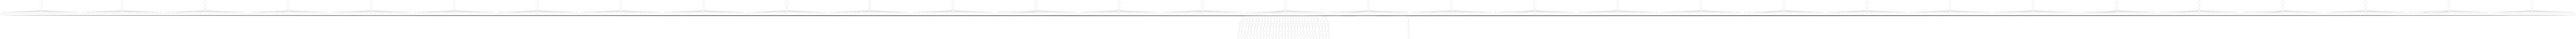

In [30]:
features.visualize()

In [37]:
features.head()

,segment_id,variable,value
0,1402674973,sensor_1__sum_values,24162.000000
1,1402674973,sensor_1__median,0.000000
2,1402674973,sensor_1__mean,0.402693
3,1402674973,sensor_1__length,60001.000000
4,1402674973,sensor_1__standard_deviation,254.718903


In [38]:
features = features.categorize(columns=["variable"])
features = features.reset_index(drop=True)


feature_table = features.pivot_table(index="segment_id",
                                     columns="variable",
                                     values="value",
                                     aggfunc="sum")

In [39]:
df_features = feature_table.compute()

In [40]:
df_features.to

AttributeError: 'DataFrame' object has no attribute 'to'

In [38]:
df_features.columns

CategoricalIndex(['sensor_1__sum_values', 'sensor_1__median', 'sensor_1__mean',
                  'sensor_1__length', 'sensor_1__standard_deviation',
                  'sensor_1__variance', 'sensor_1__maximum',
                  'sensor_1__minimum', 'sensor_4__sum_values',
                  'sensor_4__median', 'sensor_4__mean', 'sensor_4__length',
                  'sensor_4__standard_deviation', 'sensor_4__variance',
                  'sensor_4__maximum', 'sensor_4__minimum'],
                 categories=['sensor_1__sum_values', 'sensor_1__median', 'sensor_1__mean', 'sensor_1__length', 'sensor_1__standard_deviation', 'sensor_1__variance', 'sensor_1__maximum', 'sensor_1__minimum', ...], ordered=False, name='variable', dtype='category')

### Close the Dask Cluster & Client

In [16]:
client.close()
cluster.close()